In [2]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

In [3]:
from networks_pyg.GCN import *
from datasets.Myloader import traffic_mtsc_loader
# from optim import Mytrainer
# from optim.loss import loss_function,init_center
# from datasets import dataloader_pyg as dataloader
# from datasets import Myloader
from networks_pyg.init import init_model
from optim.loss_my import anomaly_score

from sklearn.metrics import *

In [4]:
%load_ext autoreload
%autoreload 2

# Dataset Loading

In [5]:
parser = argparse.ArgumentParser(description='OCGNN')
parser.add_argument("--dataset", type=str, default='cora',
        help="dataset")
parser.add_argument("--kfold", type=int, default=None,
        help="K-fold cross validation")
parser.add_argument("--dropout", type=float, default=0.25,
        help="dropout probability")
parser.add_argument("--nu", type=float, default=0.01, # 0.2
        help="hyperparameter nu (must be 0 < nu <= 1)")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--seed", type=int, default=52,
        help="random seed, -1 means dont fix seed")
parser.add_argument("--module", type=str, default='GraphSAGE',
        help="GCN/GAT/GIN/GraphSAGE/GAE")
parser.add_argument('--n-worker', type=int,default=1,
        help='number of workers when dataloading')
parser.add_argument('--batch-size', type=int,default=128,
        help='batch size')
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--n-epochs", type=int, default=100,
        help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=32,
        help="number of hidden gnn units")
parser.add_argument("--n-layers", type=int, default=2,
        help="number of hidden gnn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
        help="Weight for L2 loss")
parser.add_argument('--early-stop', action='store_true', default=False,
                    help="indicates whether to use early stop or not")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.add_argument("--norm", action='store_true',
        help="graph normalization (default=False)")
parser.add_argument("--reverse", default=False,
        help='Reverse of the adjacency matrix')
parser.add_argument("--exp-name", default='test',
        help='exp name to save model and log')
parser.set_defaults(self_loop=True)
parser.set_defaults(norm=False)
# args = parser.parse_args()
args = parser.parse_args(args=[])
# if args.module=='GCN':
#     #args.self_loop=True
#     args.norm=True
# if args.module=='GAE':
#     args.lr=0.002
#     args.dropout=0.
#     args.weight_decay=0.
#     # args.n_hidden=32
# #     args.self_loop=True
# # if args.module=='GraphSAGE':
# #     args.self_loop=True


In [6]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'



## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of filtered Events =  849


In [7]:
## https://github.com/mangushev/mtad-tf/blob/main/evaluate.py
#just like onmianomaly, no delta. If we hit anuthing in anomaly interval, whole anomaly segment is correctly identified
#-----------------------
#1|0|1|1|1|0|0|0|1|1|1|1  Labels
#-----------------------
#0|0|0|1|1|0|0|0|0|0|1|0  Predictions
#-----------------------
#0|0|1|1|1|0|0|0|1|1|1|1  Adjusted
#-----------------------
def adjust_predictions(predictions, labels):
  adjustment_started = False
  new_pred = predictions

  for i in range(len(predictions)):
    if labels[i] == 1:
      if predictions[i] == 1:
        if not adjustment_started:
          adjustment_started = True
          for j in range(i, 0, -1):
            if labels[j] == 1:
              new_pred[j] = 1
            else:
              break
    else:
      adjustment_started = False

    if adjustment_started:
      new_pred[i] = 1
      
  return new_pred

In [8]:
def evaluate(true, pred, score, adjust = False, plot=False, print_=False):
#     true = label_all
#     pred = list(map(int, [s>0 for s in score_all]))
    if adjust:
        pred = adjust_predictions(pred, true)
    CM = confusion_matrix(true, pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    acc = accuracy_score(true, pred)
    # auc = roc_auc_score(true, pred)
    auc = roc_auc_score(true, score)
#     far = FP / (FP+TN)
    far = FP / (TP+FP)
    pre = precision_score(true, pred, pos_label=1)
    rec = recall_score(true, pred, pos_label=1)
    macro_f1 = f1_score(true, pred, average='macro')
    weighted_f1 = f1_score(true, pred, average='weighted')
    ap = average_precision_score(true, score)
    # ap = average_precision_score(true, pred)
    if plot:
        plt.figure(figsize=(40, 5))
        plt.plot(true)
        plt.plot(pred)
    if print_:
        print('Accuracy \t{:.4f}'.format(acc))
        print('AUC score \t{:.4f}'.format(auc))
        print('FAR score \t{:.4f}'.format(far))
        print('Precision \t{:.4f}'.format(pre))
        print('Recall   \t{:.4f}'.format(rec))
        print('Macro F1 \t{:.4f}'.format(macro_f1))
        print('weighted F1 \t{:.4f}'.format(weighted_f1))
        print('Avg Precision \t{:.4f}'.format(ap))
        print(classification_report(true, pred))
    return [acc, auc, far, pre, rec, macro_f1, weighted_f1, ap]

# 1. Anomaly Ratio Check

In [9]:
for target_sid in ['1210005301']:   ## 1210005301  ## 1030001902
    anomaly_ratio_all = []
    num_samples_all = []
    for k in range(10):
        args.dataset = '{}_CV1'.format(target_sid)
        args.kfold = k
        args.bidirect = False
        print(args.dataset, args.kfold)
        train_loader, val_loader, test_loader = traffic_mtsc_loader(args)

        y_all = []
        for data in train_loader:
            y_all.append(data.y)
        y_all = torch.concat(y_all).unique(return_counts=True)
        train_ratio = y_all[1][1] / y_all[1].sum()
        num_train = y_all[1].sum()

        y_all = []
        for data in val_loader:
            y_all.append(data.y)
        y_all = torch.concat(y_all).unique(return_counts=True)
        if len(y_all[1]) == 1:
            val_ratio = 0
        else:
            val_ratio = y_all[1][1] / y_all[1].sum()
        num_val = y_all[1].sum()
        
        y_all = []
        for data in test_loader:
            y_all.append(data.y)
        y_all = torch.concat(y_all).unique(return_counts=True)
        if len(y_all[1]) == 1:
            test_ratio = 0
        else:
            test_ratio = y_all[1][1] / y_all[1].sum()
        num_test = y_all[1].sum()

        print(train_ratio, val_ratio, test_ratio)
        
        anomaly_ratio_all.append([train_ratio, val_ratio, test_ratio])
        num_samples_all.append([num_train, num_val, num_test])
        


1210005301_CV1 0


/home/jiin/anaconda3/envs/AID/lib/python3.10/site-packages/torch_geometric/utils/convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data[key] = torch.tensor(value)


tensor(0.0272) tensor(0.0058) tensor(0.0264)
1210005301_CV1 1
tensor(0.0230) tensor(0.0081) tensor(0.0391)
1210005301_CV1 2
tensor(0.0225) tensor(0.0297) tensor(0.0174)
1210005301_CV1 3
tensor(0.0221) tensor(0.0349) tensor(0.0139)
1210005301_CV1 4
tensor(0.0210) tensor(0.0354) tensor(0.0159)
1210005301_CV1 5
tensor(0.0243) tensor(0.0050) tensor(0.0360)
1210005301_CV1 6
tensor(0.0169) tensor(0.0247) tensor(0.0415)
1210005301_CV1 7
tensor(0.0268) tensor(0.0262) tensor(0.0062)
1210005301_CV1 8
tensor(0.0114) tensor(0.0571) tensor(0.0185)
1210005301_CV1 9
tensor(0.0156) tensor(0.0683) tensor(0.0049)


In [10]:
np.mean(anomaly_ratio_all, axis=0), np.std(anomaly_ratio_all, axis=0)

(array([0.02107533, 0.02952106, 0.02198227], dtype=float32),
 array([0.00478347, 0.0199711 , 0.0125184 ], dtype=float32))

In [11]:
np.sum(num_samples_all, axis=1), np.mean(num_samples_all, axis=0)

(array([11709, 11709, 11709, 11709, 11709, 11709, 11709, 11709, 11709,
        11709]),
 array([7152.7, 2325.9, 2230.4]))

# 2. Cross Validation Results

In [20]:
## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
accident_all['created'] = pd.to_datetime(accident_all['created'])
print("# of filtered Events = ", len(accident_all))

# of filtered Events =  849


In [21]:
target_sid = 1210005301 ## 1210005301  ## 1030001902  ## 1220005401  ## 1210003000  ## 1130052300
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]
args.dataset = '{}_CV'.format(target_sid)

args.gpu = 0
if args.gpu < 0:
    device = torch.device('cpu')
else:
    device = torch.device(f'cuda:{args.gpu}')

In [22]:
print(args.dataset)
# result_all = pd.read_csv('result/{}_sumpool_nu.csv'.format(args.dataset), index_col=0)
result_all = pd.read_csv('result/{}_sumpool_0.97.csv'.format(args.dataset), index_col=0)

1210005301_CV


In [23]:
pd.pivot_table(result_all[(result_all.adjust == True)], index=['nu','model',], aggfunc='mean')

AP       AUC        DR  F1_macro  F1_weight  Kfold  \
nu   model                                                                 
0.01 GAT        0.070484  0.713084  0.193379  0.556997   0.959279    4.5   
     GCN        0.045675  0.685088  0.162195  0.541580   0.957297    4.5   
     GraphSAGE  0.054064  0.594900  0.116443  0.522818   0.954551    4.5   
     STGCN      0.081112  0.824768  0.112213  0.515610   0.956016    4.5   
0.03 GAT        0.074141  0.739250  0.182370  0.548542   0.958111    4.5   
     GCN        0.044708  0.703563  0.092325  0.513738   0.953263    4.5   
     GraphSAGE  0.078313  0.676609  0.237830  0.568843   0.956415    4.5   
     STGCN      0.105981  0.834997  0.118137  0.533802   0.959974    4.5   
0.05 GAT        0.072183  0.670952  0.191178  0.546862   0.958483    4.5   
     GCN        0.062975  0.749880  0.151253  0.541209   0.958229    4.5   
     GraphSAGE  0.065244  0.616452  0.091894  0.527489   0.959202    4.5   
     STGCN      0.105302  0.827133  0.142978  0.532458   0.957696    4.5   
0.10 GAT        0.082635  0.769351  0.240614  0.556669   0.958578    4.5   
     GCN        0.069299  0.774414  0.152387  0.535206   0.956726    4.5   
     GraphSAGE  0.076310  0.707410  0.090862  0.521081   0.955412    4.5   
     STGCN      0.113537  0.865630  0.111596  0.530297   0.958587    4.5   
0.20 GAT        0.076173  0.715261  0.149380  0.540833   0.959043    4.5   
     GCN        0.064989  0.730963  0.083684  0.512208   0.955504    4.5   
     GraphSAGE  0.068774  0.751599  0.138201  0.535648   0.957452    4.5   
     STGCN      0.113177  0.874025  0.127377  0.537748   0.959472    4.5   

                     acc  adjust       far  precision    recall  
nu   model                                                       
0.01 GAT        0.954448     1.0  0.877562   0.122438  0.193379  
     GCN        0.952347     1.0  0.914227   0.085773  0.162195  
     GraphSAGE  0.949074     1.0  0.946855   0.053145  0.116443  
     STGCN      0.952483     1.0  0.957207   0.042793  0.112213  
0.03 GAT        0.953221     1.0  0.893670   0.106330  0.182370  
     GCN        0.947030     1.0  0.959429   0.040571  0.092325  
     GraphSAGE  0.947677     1.0  0.858062   0.141938  0.237830  
     STGCN      0.957353     1.0  0.907273   0.092727  0.118137  
0.05 GAT        0.955003     1.0  0.895957   0.104043  0.191178  
     GCN        0.954162     1.0  0.910102   0.089898  0.151253  
     GraphSAGE  0.956987     1.0  0.922095   0.077905  0.091894  
     STGCN      0.953330     1.0  0.912416   0.087584  0.142978  
0.10 GAT        0.954964     1.0  0.888291   0.111709  0.240614  
     GCN        0.951835     1.0  0.918969   0.081031  0.152387  
     GraphSAGE  0.950026     1.0  0.938597   0.061403  0.090862  
     STGCN      0.955013     1.0  0.905384   0.094616  0.111596  
0.20 GAT        0.955868     1.0  0.895626   0.104374  0.149380  
     GCN        0.951688     1.0  0.958532   0.041468  0.083684  
     GraphSAGE  0.952126     1.0  0.915116   0.084884  0.138201  
     STGCN      0.955967     1.0  0.898875   0.101125  0.127377

In [19]:
result_all[(result_all.adjust==True)&(result_all.model=='STGCN')].sort_values('AUC')[-10:]

,model,Kfold,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
319,STGCN,6,0.30,True,0.213483,0.627451,0.372549,0.213483,0.952403,0.923285,0.623413,0.946162,0.303627
239,STGCN,4,0.50,True,0.000000,1.000000,0.000000,0.000000,0.968651,0.924944,0.492038,0.968427,0.097014
327,STGCN,6,0.40,True,0.168539,0.634146,0.365854,0.168539,0.953336,0.930681,0.603354,0.944991,0.335803
295,STGCN,6,0.01,True,0.213483,0.627451,0.372549,0.213483,0.952403,0.934461,0.623413,0.946162,0.326245
455,STGCN,9,0.20,True,0.250000,0.953846,0.046154,0.250000,0.971115,0.966340,0.531625,0.980898,0.068126
479,STGCN,9,0.50,True,0.250000,0.951613,0.048387,0.250000,0.972335,0.969781,0.533519,0.981539,0.074852
463,STGCN,9,0.30,True,0.333333,0.944444,0.055556,0.333333,0.969081,0.971586,0.539755,0.979931,0.080221
439,STGCN,9,0.01,True,0.333333,0.927273,0.072727,0.333333,0.975997,0.971961,0.553618,0.983593,0.087185
447,STGCN,9,0.10,True,0.333333,0.914894,0.085106,0.333333,0.979251,0.972404,0.562546,0.985331,0.084425
471,STGCN,9,0.40,True,0.333333,0.932203,0.067797,0.333333,0.974369,0.974005,0.549836,0.982728,0.088393


# 3. Case Result

### Settings & Loading

In [16]:
## GPU device setting
args.gpu = 1
if args.gpu < 0:
    device = torch.device('cpu')
else:
    device = torch.device(f'cuda:{args.gpu}')

In [17]:
## target incidents

target_sid = 1210005301 ## 1210005301 ## 1030001902
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]

In [18]:
data_extraction_path = '/media/usr/HDD/Data/NAVER_df'
with open(os.path.join(data_extraction_path, str(eventID)), 'rb') as f:
        test = pickle.load(f)

path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

hop1_up = list(np.unique([p[1] for p in path_inflow]))
hop1_down = list(np.unique([p[1] for p in path_outflow]))

test_df = pd.read_csv('../data/{}/test_x.csv'.format(target_sid), index_col=0)
test_df.columns = test_df.columns.astype(int)

In [19]:
def speed_agg(test_df):

    df_agg_inflow, df_agg_outflow = [], []
    for hop in [0, 1, 2, 3]:
        inflow = np.unique([p[hop] for p in path_inflow])
        outflow = np.unique([p[hop] for p in path_outflow])
        inflow = [p for p in inflow if p in list(test_df.columns)]
        outflow = [p for p in outflow if p in list(test_df.columns)]
        df_agg_inflow.append(test_df[inflow].mean(axis=1))
        df_agg_outflow.append(test_df[outflow].mean(axis=1))
    df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
    df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

    return df_agg_inflow, df_agg_outflow

In [20]:
args.dataset = '{}_CV2'.format(target_sid)
args.bias = True
args.kfold = 6

args.module = 'STGCN'
name = 'STGCN'
args.nu = 0.1
args.self_loop = 'True'
args.pooling = 'sum'
args.bias = True
args.exp_name = f'{args.dataset}_{args.kfold}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'

train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
print(len(train_loader), len(val_loader), len(test_loader))

55 19 17


In [21]:
checkpoints_path=f'./checkpoints_SAD_CV/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
checkpoints_path

'./checkpoints_SAD_CV/1210005301_CV2/1210005301_CV2_6_STGCN_sum_0.1_True+bestcheckpoint.pt'

In [22]:
## Model loading

input_dim = 24
model = init_model(args, input_dim)
model.load_state_dict(torch.load(checkpoints_path, map_location=device)['model'])
model.to(device=device)
model.eval()
data_center = torch.load(checkpoints_path, map_location=device)['data_center']
radius = torch.load(checkpoints_path, map_location=device)['radius']
data_center, radius

Parameter number of STGCN Net is: 4532


(tensor([-3.6021, -2.4573, -0.1283,  3.0594,  3.4015,  1.4694, -3.5890, -3.6679,
         -0.4475, -3.6723,  3.8381,  5.8104, -0.6531,  3.1797, -2.5376, -2.5995,
          0.6408,  4.4433,  3.7727, -1.9817,  0.7331,  0.3959, -0.2030, -1.2198,
         -2.9490, -1.3315, -1.4943, -3.1545,  0.6372,  3.6172, -0.7155,  0.4188],
        device='cuda:1'),
 tensor(1.9962, device='cuda:1', dtype=torch.float64))

### Prediction

In [23]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(val_loader)):
    output = model(data.to(device=device))
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    # dist, score = anomaly_score(data_center, output, radius)
    dist = torch.sum((output - data_center) ** 2, dim=1)
    dist_all.append(dist.cpu().detach().numpy())
    # score_all.append(score.cpu().detach().numpy())
# label_all = np.concatenate(label_all)
# score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)
print(dist_all[:5])
# new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius = np.quantile(np.sqrt(dist_all), 0.95)
new_radius

19it [00:03,  6.17it/s]

[3.1776261 3.1602592 3.112825  3.053963  3.0603771]


1.7535195648670197

In [24]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(test_loader)):
    output = model(data.to(device=f'cuda:{args.gpu}'))
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, new_radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)

17it [00:00, 18.67it/s]


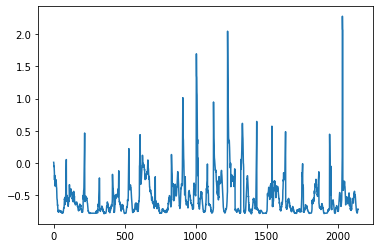

In [25]:
plt.plot(score_all)

Accuracy 	0.9515
AUC score 	0.9372
FAR score 	0.5773
Precision 	0.4227
Recall   	0.4607
Macro F1 	0.7077
weighted F1 	0.9525
Avg Precision 	0.3547
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2054
           1       0.42      0.46      0.44        89

    accuracy                           0.95      2143
   macro avg       0.70      0.72      0.71      2143
weighted avg       0.95      0.95      0.95      2143



[0.9514699020065329,
 0.9372011859566972,
 0.5773195876288659,
 0.422680412371134,
 0.4606741573033708,
 0.7077471806976134,
 0.952466213590831,
 0.3547018238438976]

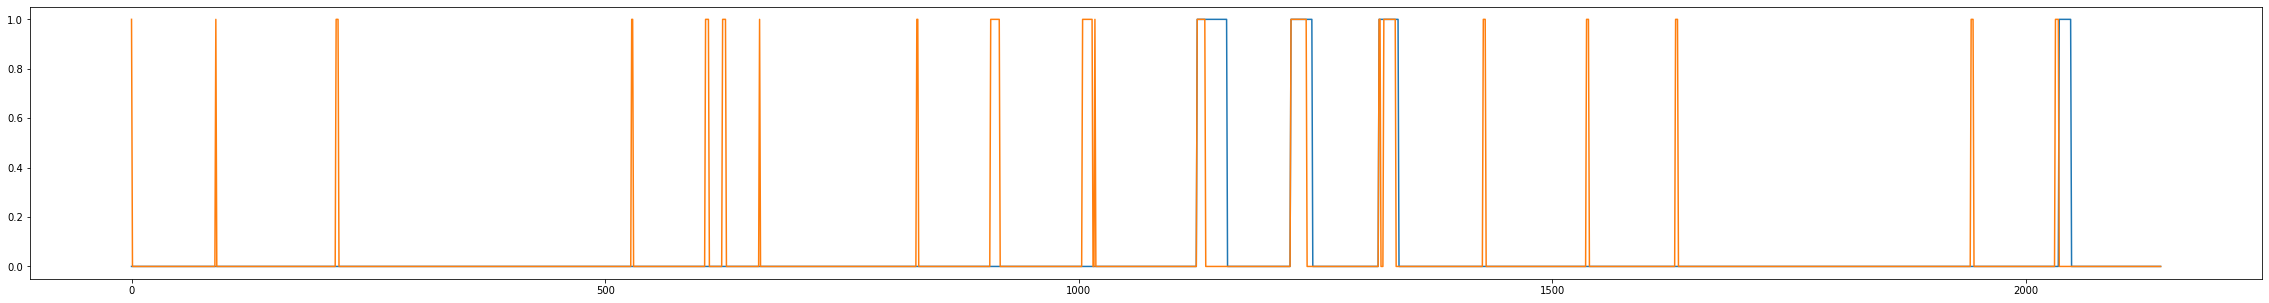

In [26]:
pred = [1 if s > 0 else 0 for s in score_all]
evaluate(label_all, pred, score_all, adjust=False, plot=True, print_=True)

Accuracy 	0.9678
AUC score 	0.9372
FAR score 	0.4242
Precision 	0.5758
Recall   	0.8539
Macro F1 	0.8354
weighted F1 	0.9708
Avg Precision 	0.3547
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2054
           1       0.58      0.85      0.69        89

    accuracy                           0.97      2143
   macro avg       0.78      0.91      0.84      2143
weighted avg       0.98      0.97      0.97      2143



[0.9678021465235651,
 0.9372011859566972,
 0.42424242424242425,
 0.5757575757575758,
 0.8539325842696629,
 0.8354043178440833,
 0.9707642207343964,
 0.3547018238438976]

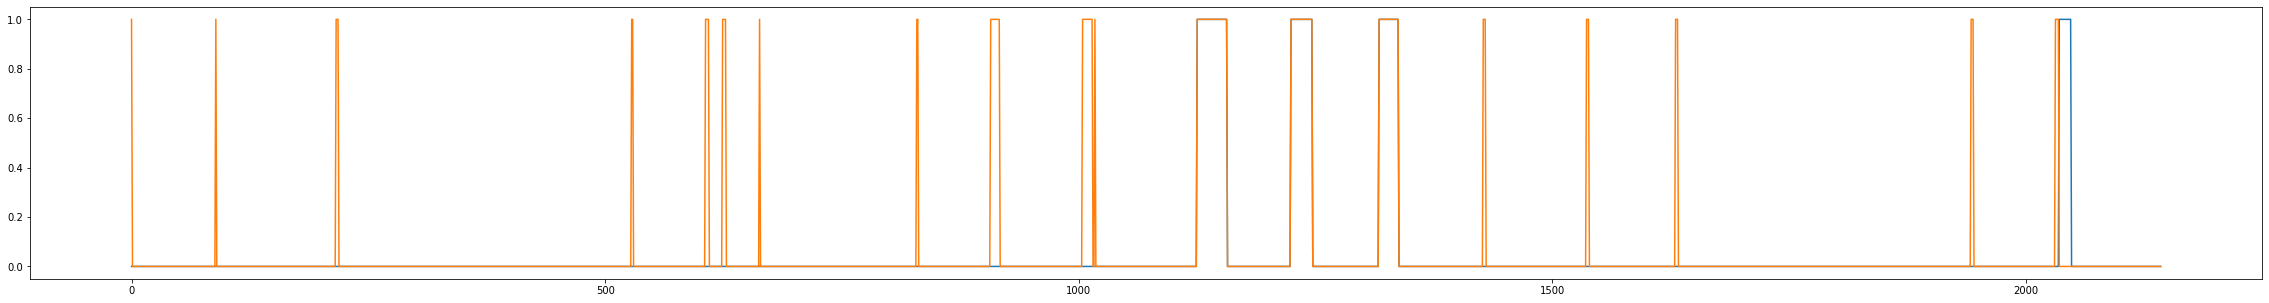

In [27]:
pred = [1 if s > 0 else 0 for s in score_all]
evaluate(label_all, pred, score_all, adjust=True, plot=True, print_=True)

In [28]:
cm = confusion_matrix(label_all, (score_all > 0).astype(int))
cm

array([[1998,   56],
       [  48,   41]])

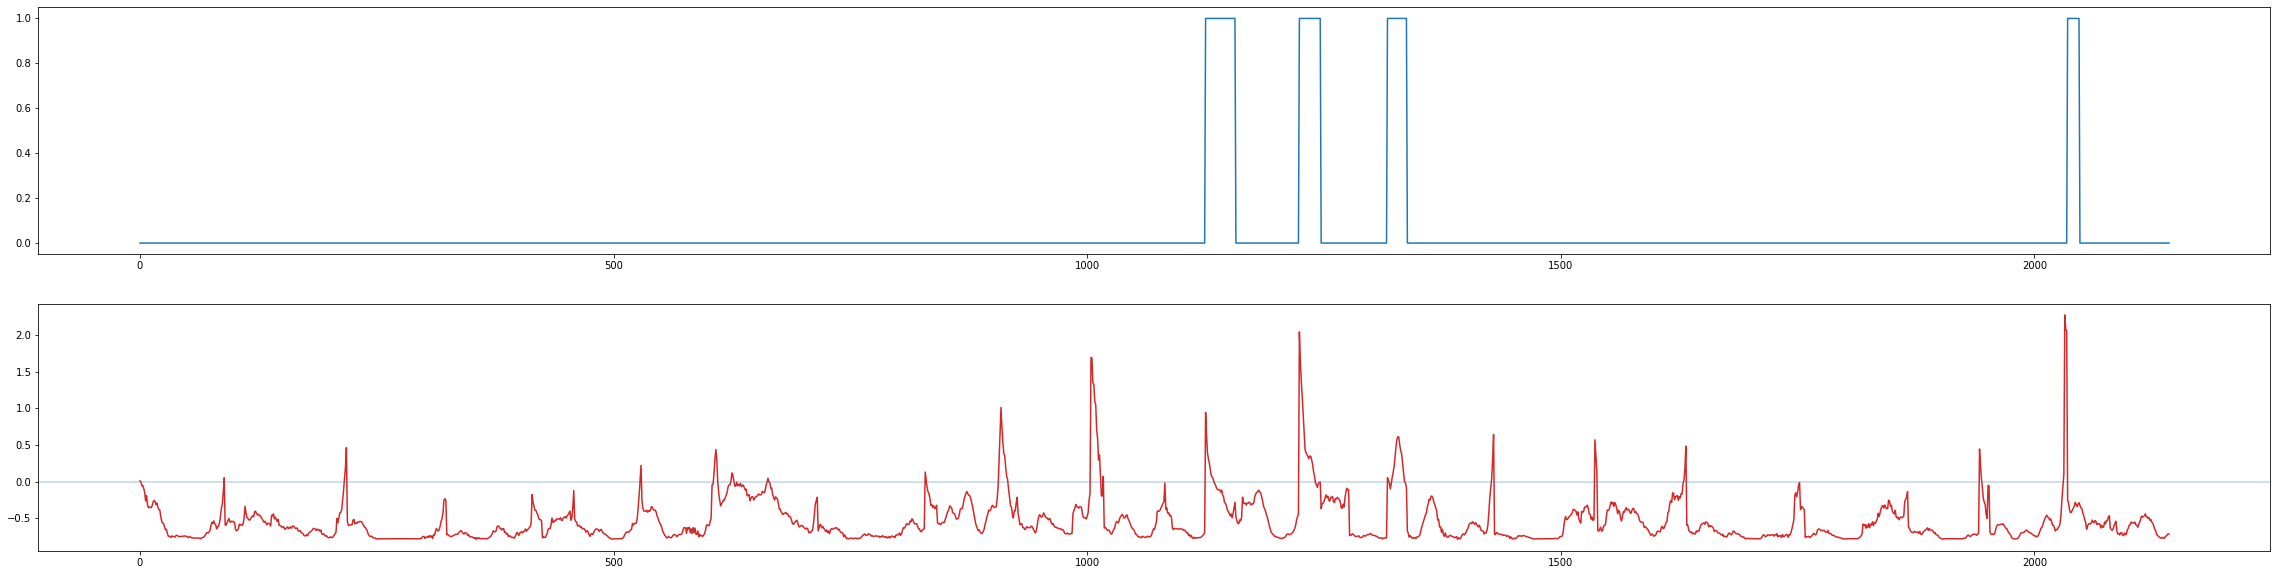

In [29]:
true = label_all
pred = list(map(int, [s>0 for s in score_all]))
plt.figure(figsize=(40, 10))
plt.subplot(2, 1, 1)
plt.plot(true[:4000])
plt.subplot(2, 1, 2)
plt.plot(score_all[:4000], color='tab:red')
# plt.ylim(-0.005, 0.01)
plt.axhline(0, alpha=0.3)


### Prediction profiles plot

In [30]:
tp = np.where((label_all == 1) & ((score_all > 0).astype(int) == 1))[0]
fp = np.where((label_all == 0) & ((score_all > 0).astype(int) == 1))[0]
tn = np.where((label_all == 0) & ((score_all > 0).astype(int) == 0))[0]
fn = np.where((label_all == 1) & ((score_all > 0).astype(int) == 0))[0]

pred_anomaly = np.where(score_all > 0)[0]

[1326 1326 1230 1236 1230 1131 1126 1236 1330 1326]


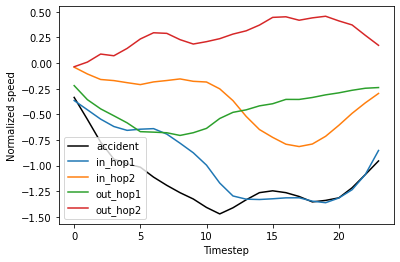

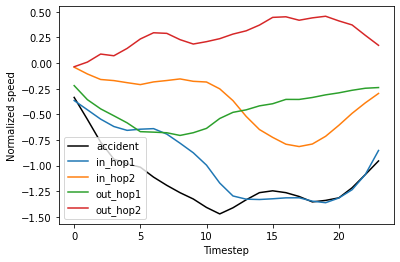

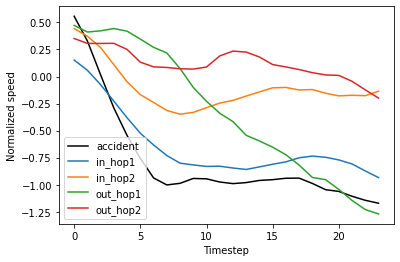

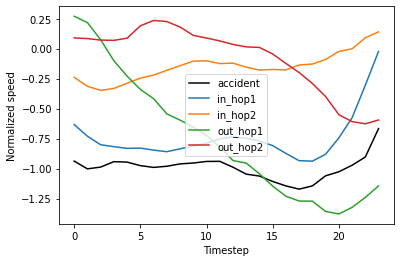

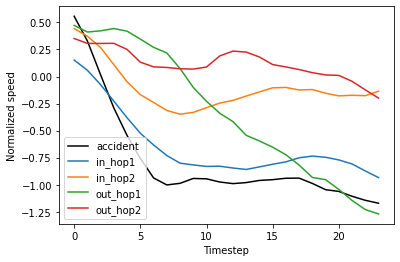

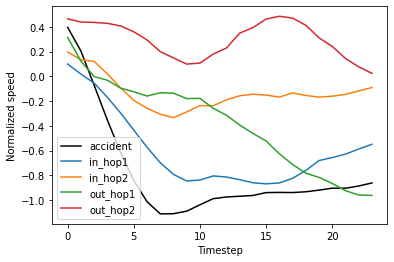

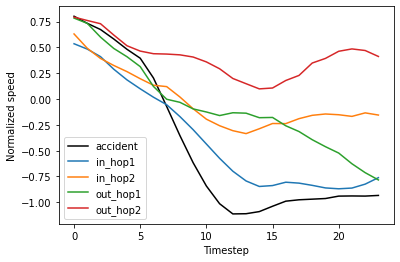

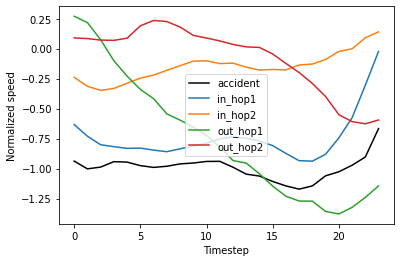

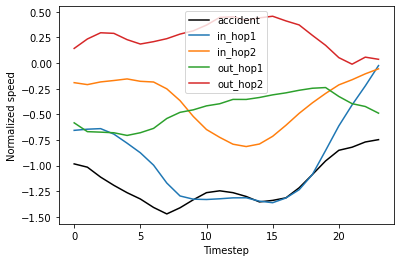

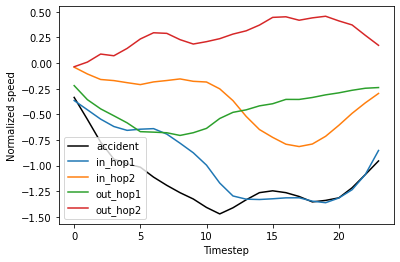

In [31]:
bs = args.batch_size
n_node = 25

tmp = np.random.choice(tp, 10)
print(tmp)

for detected in tmp:
    i = detected // args.batch_size
    j = detected % args.batch_size

    for ix, data in enumerate(test_loader):
        if ix == i:
            tmp_df = pd.DataFrame(data.x[data.batch == j], index=test_df.columns.astype(int)).T
            df_agg_inflow, df_agg_outflow = speed_agg(tmp_df)


    plt.figure()
    plt.plot(df_agg_inflow[0], label='accident', color='k')
    plt.plot(df_agg_inflow[1], label='in_hop1')
    plt.plot(df_agg_inflow[2], label='in_hop2')
    plt.plot(df_agg_outflow[2], label='out_hop1')
    plt.plot(df_agg_outflow[1], label='out_hop2')
    plt.legend()
    plt.ylabel('Normalized speed')
    plt.xlabel('Timestep')
    plt.show()

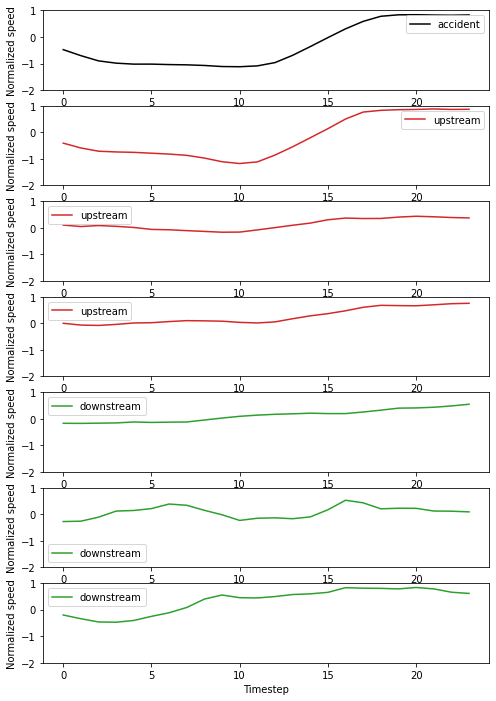

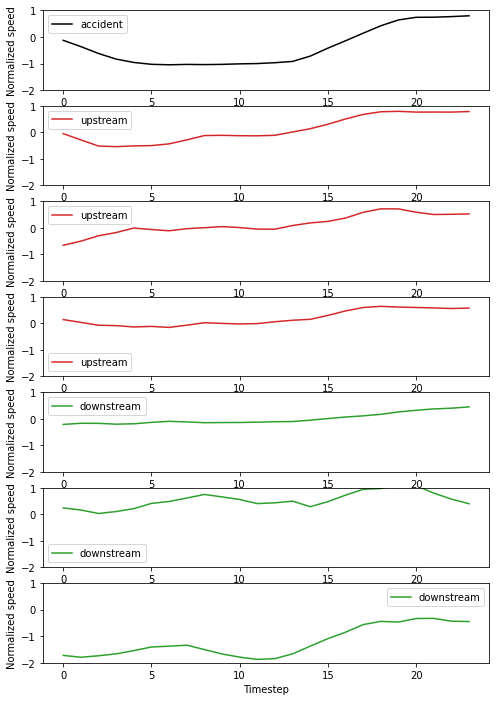

In [32]:
bs = args.batch_size
n_node = 25
for detected in pred_anomaly[4:6]:
    i = detected // args.batch_size
    j = detected % args.batch_size

    for ix, data in enumerate(test_loader):
        if ix == i:
            tmp_df = pd.DataFrame(data.x[data.batch == j], index=test_df.columns.astype(int)).T
            df_agg_inflow, df_agg_outflow = speed_agg(tmp_df)


    fig, ax = plt.subplots(7, 1, figsize=(8, 12))
    ax[0].plot(tmp_df[target_sid], label='accident', color='k')
    ax[1].plot(tmp_df[hop1_up[0]], label='upstream', color='tab:red')
    ax[2].plot(tmp_df[hop1_up[1]], label='upstream', color='tab:red')
    ax[3].plot(tmp_df[hop1_up[3]], label='upstream', color='tab:red')
    ax[4].plot(tmp_df[hop1_down[0]], label='downstream', color='tab:green')
    ax[5].plot(tmp_df[hop1_down[1]], label='downstream', color='tab:green')
    ax[6].plot(tmp_df[hop1_down[2]], label='downstream', color='tab:green')
    
    
    for k in range(7):
        ax[k].set_ylim(-2, 1)
        ax[k].legend()
        ax[k].set_ylabel('Normalized speed')
        ax[k].set_xlabel('Timestep')
    plt.show()

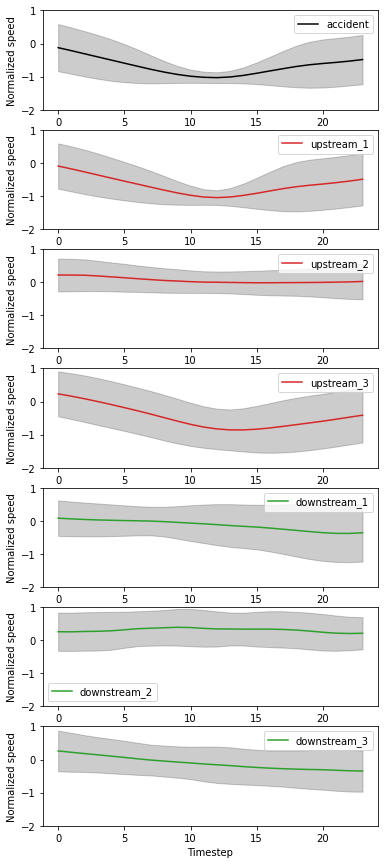

In [33]:
bs = args.batch_size
n_node = 25
pattern_all = []
for detect_ix in pred_anomaly:
# for detect_ix in fp:
    i = detect_ix // args.batch_size
    j = detect_ix % args.batch_size


    for ix, data in enumerate(test_loader):
        if ix == i:
            tmp_df = pd.DataFrame(data.x[data.batch == j]).T
            pattern_all.append(tmp_df)
            df_agg_inflow, df_agg_outflow = speed_agg(tmp_df)
            break


pattern_mean = pd.DataFrame(np.nanmean(pattern_all, axis=0), columns=test_df.columns.astype(int))
pattern_std = pd.DataFrame(np.nanstd(pattern_all, axis=0), columns=test_df.columns.astype(int))
pattern_ub = pattern_mean + pattern_std
pattern_lb = pattern_mean - pattern_std

fig, ax = plt.subplots(7, 1, figsize=(6, 15))
ax[0].plot(pattern_mean[target_sid], label='accident', color='k')
ax[0].fill_between(np.arange(24), pattern_lb[target_sid], pattern_ub[target_sid], color='k', alpha=0.2)

ax[1].plot(pattern_mean[hop1_up[0]], label='upstream_1', color='tab:red')
ax[1].fill_between(np.arange(24), pattern_lb[hop1_up[0]], pattern_ub[hop1_up[0]], color='k', alpha=0.2)

ax[2].plot(pattern_mean[hop1_up[1]], label='upstream_2', color='tab:red')
ax[2].fill_between(np.arange(24), pattern_lb[hop1_up[1]], pattern_ub[hop1_up[1]], color='k', alpha=0.2)

ax[3].plot(pattern_mean[hop1_up[3]], label='upstream_3', color='tab:red')
ax[3].fill_between(np.arange(24), pattern_lb[hop1_up[3]], pattern_ub[hop1_up[3]], color='k', alpha=0.2)

ax[4].plot(pattern_mean[hop1_down[0]], label='downstream_1', color='tab:green')
ax[4].fill_between(np.arange(24), pattern_lb[hop1_down[0]], pattern_ub[hop1_down[0]], color='k', alpha=0.2)

ax[5].plot(pattern_mean[hop1_down[1]], label='downstream_2', color='tab:green')
ax[5].fill_between(np.arange(24), pattern_lb[hop1_down[1]], pattern_ub[hop1_down[1]], color='k', alpha=0.2)

ax[6].plot(pattern_mean[hop1_down[2]], label='downstream_3', color='tab:green')
ax[6].fill_between(np.arange(24), pattern_lb[hop1_down[2]], pattern_ub[hop1_down[2]], color='k', alpha=0.2)


for k in range(7):
    ax[k].set_ylim(-2, 1)
    ax[k].legend()
    ax[k].set_ylabel('Normalized speed')
    ax[k].set_xlabel('Timestep')
plt.show()

### True profiles plot

In [34]:
RC = np.where((label_all == 0))[0]
NRC = np.where((label_all == 1))[0]

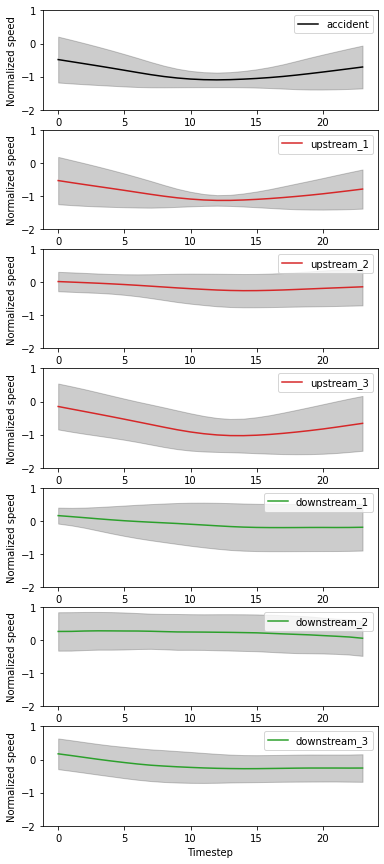

In [35]:
bs = args.batch_size
n_node = 25
pattern_all = []
for detect_ix in NRC:
# for detect_ix in np.random.choice(RC, 100):
    i = detect_ix // args.batch_size
    j = detect_ix % args.batch_size


    for ix, data in enumerate(test_loader):
        if ix == i:
            tmp_df = pd.DataFrame(data.x[data.batch == j]).T
            pattern_all.append(tmp_df)
            df_agg_inflow, df_agg_outflow = speed_agg(tmp_df)
            break


pattern_mean = pd.DataFrame(np.nanmean(pattern_all, axis=0), columns=test_df.columns.astype(int))
pattern_std = pd.DataFrame(np.nanstd(pattern_all, axis=0), columns=test_df.columns.astype(int))
pattern_ub = pattern_mean + pattern_std
pattern_lb = pattern_mean - pattern_std

fig, ax = plt.subplots(7, 1, figsize=(6, 15))
ax[0].plot(pattern_mean[target_sid], label='accident', color='k')
ax[0].fill_between(np.arange(24), pattern_lb[target_sid], pattern_ub[target_sid], color='k', alpha=0.2)

ax[1].plot(pattern_mean[hop1_up[0]], label='upstream_1', color='tab:red')
ax[1].fill_between(np.arange(24), pattern_lb[hop1_up[0]], pattern_ub[hop1_up[0]], color='k', alpha=0.2)

ax[2].plot(pattern_mean[hop1_up[1]], label='upstream_2', color='tab:red')
ax[2].fill_between(np.arange(24), pattern_lb[hop1_up[1]], pattern_ub[hop1_up[1]], color='k', alpha=0.2)

ax[3].plot(pattern_mean[hop1_up[3]], label='upstream_3', color='tab:red')
ax[3].fill_between(np.arange(24), pattern_lb[hop1_up[3]], pattern_ub[hop1_up[3]], color='k', alpha=0.2)

ax[4].plot(pattern_mean[hop1_down[0]], label='downstream_1', color='tab:green')
ax[4].fill_between(np.arange(24), pattern_lb[hop1_down[0]], pattern_ub[hop1_down[0]], color='k', alpha=0.2)

ax[5].plot(pattern_mean[hop1_down[1]], label='downstream_2', color='tab:green')
ax[5].fill_between(np.arange(24), pattern_lb[hop1_down[1]], pattern_ub[hop1_down[1]], color='k', alpha=0.2)

ax[6].plot(pattern_mean[hop1_down[2]], label='downstream_3', color='tab:green')
ax[6].fill_between(np.arange(24), pattern_lb[hop1_down[2]], pattern_ub[hop1_down[2]], color='k', alpha=0.2)



for k in range(7):
    ax[k].set_ylim(-2, 1)
    ax[k].legend()
    ax[k].set_ylabel('Normalized speed')
    ax[k].set_xlabel('Timestep')
plt.show()

### Prediction Case for true incident

In [36]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    inflow = [p for p in inflow if p in list(test_df.columns)]
    outflow = [p for p in outflow if p in list(test_df.columns)]
    df_agg_inflow.append(test_df[inflow].mean(axis=1))
    df_agg_outflow.append(test_df[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

Detected
MTTD = [0]


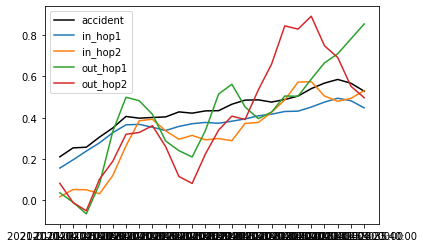

Detected
MTTD = [0]


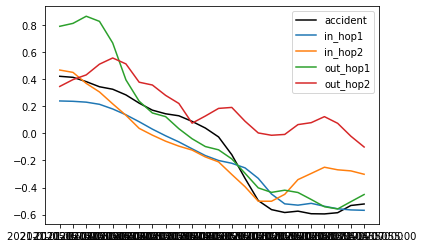

Detected
MTTD = [0]


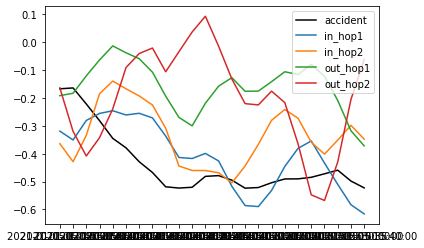

Not detected


In [37]:
st_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == 1)[0]
ed_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == -1)[0][1:]

pred = list(map(int, [s>0 for s in score_all]))

for st, ed in zip(st_time_list, ed_time_list):
    if sum(pred[st:ed]) == 0:
        print('Not detected')
    else:
        print('Detected')
        if pred[st] == 1:
            print('MTTD = [0]')
            i = st
        else:
            print('MTTD = ', np.where(np.diff(pred[st:ed], prepend=1)==1)[0])
            i = st + np.where(np.diff(pred[st:ed], prepend=1)==1)[0][0]
        plt.figure()
        plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
        plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
        plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
        plt.plot(df_agg_outflow[i:i+24][2], label='out_hop1')
        plt.plot(df_agg_outflow[i:i+24][1], label='out_hop2')
        plt.legend()
        plt.show()
    

# 4. T-SNE plot for Graph Embeddings

### All GNN architectures 

55 19 17
Parameter number of GCN_gc Net is: 7840
./checkpoints_SAD_CV/1210005301_CV2/1210005301_CV2_6_GCN_sum_0.03_True+bestcheckpoint.pt


17it [00:00, 115.25it/s]


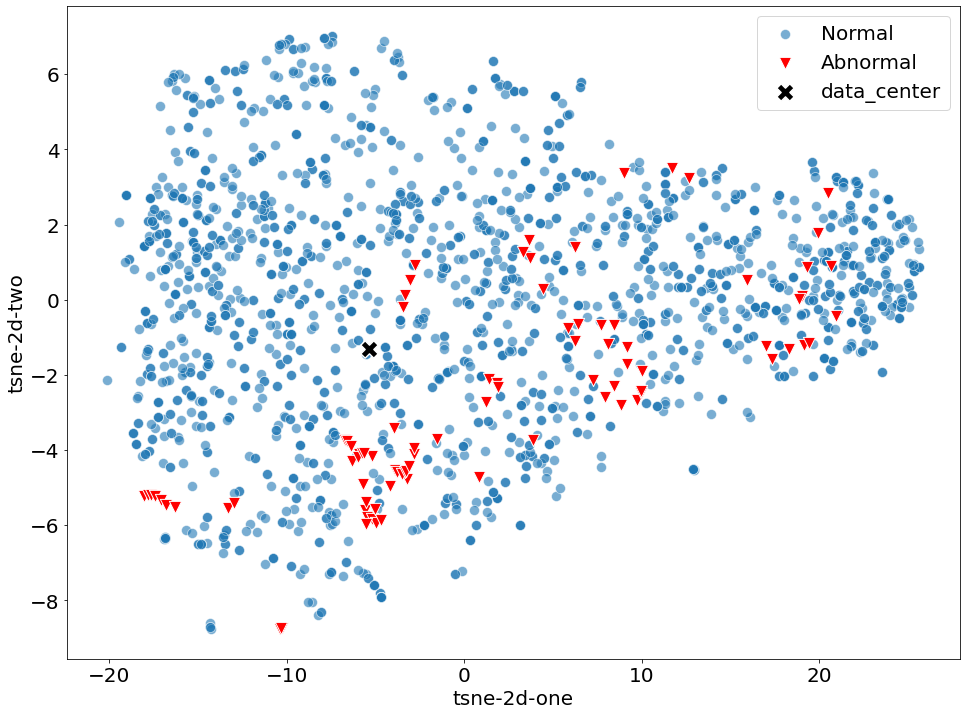

Parameter number of GAT_gc Net is: 293984
./checkpoints_SAD_CV/1210005301_CV2/1210005301_CV2_6_GAT_sum_0.03_True+bestcheckpoint.pt


17it [00:00, 129.23it/s]


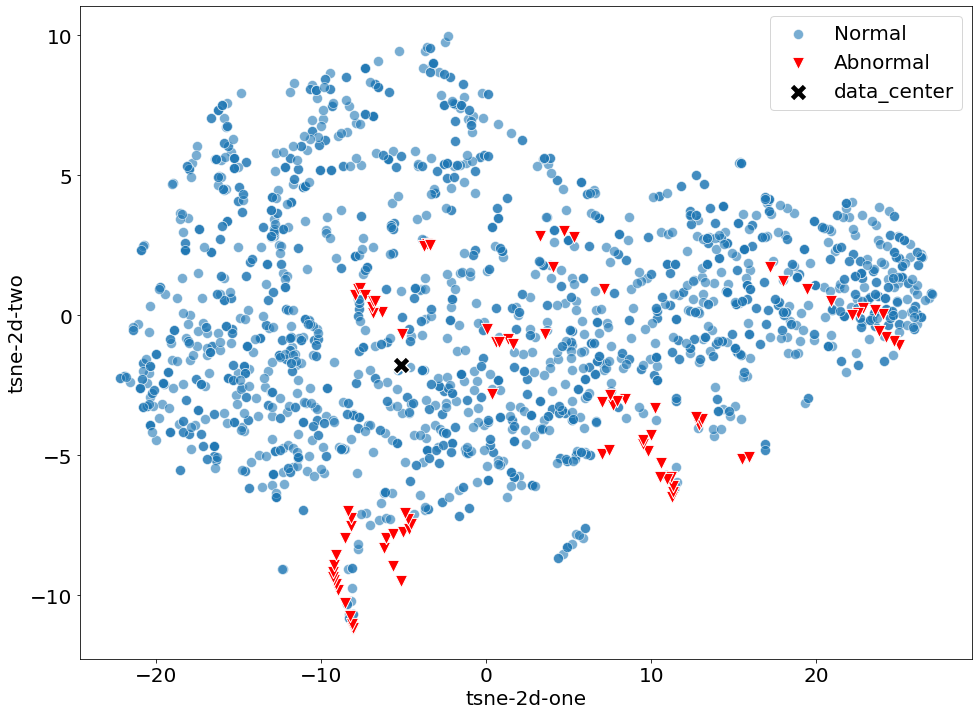

Parameter number of GraphSAGE_gc Net is: 15520
./checkpoints_SAD_CV/1210005301_CV2/1210005301_CV2_6_GraphSAGE_sum_0.03_True+bestcheckpoint.pt


17it [00:00, 119.17it/s]


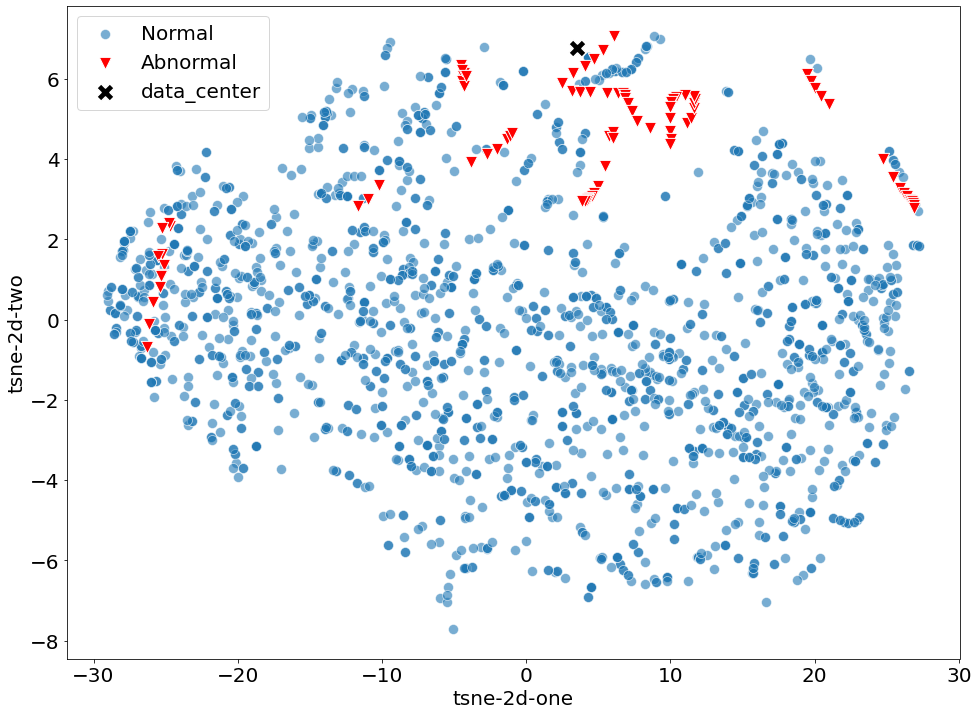

Parameter number of STGCN Net is: 4532
./checkpoints_SAD_CV/1210005301_CV2/1210005301_CV2_6_STGCN_sum_0.03_True+bestcheckpoint.pt


17it [00:00, 18.05it/s]


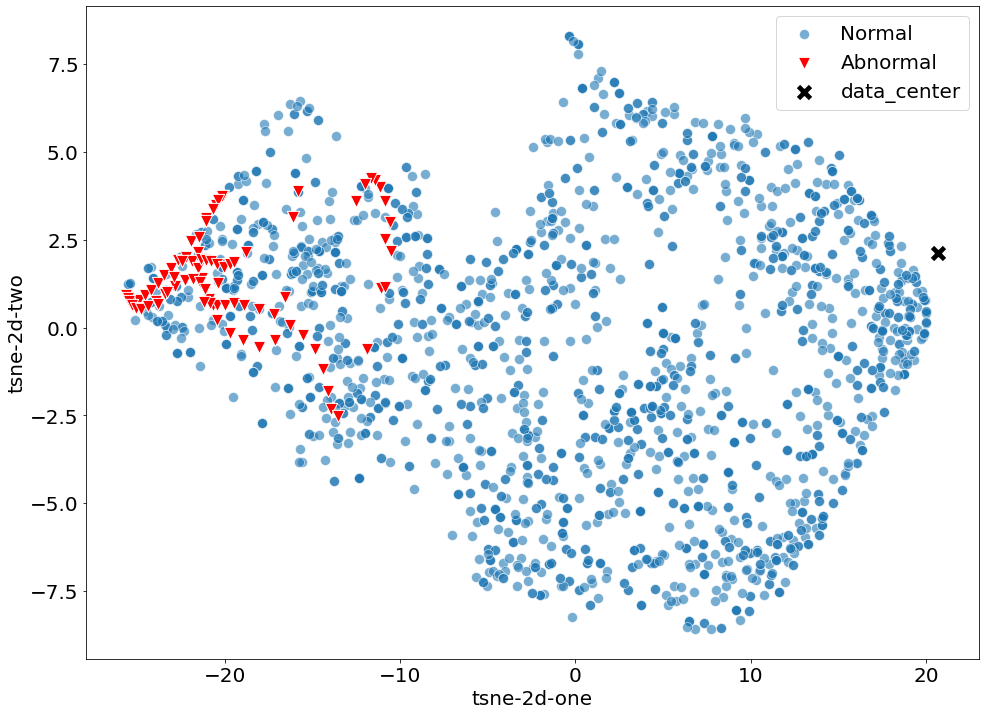

In [55]:
args.dataset = '1210005301_CV2'
args.kfold = 6
train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
print(len(train_loader), len(val_loader), len(test_loader))


for module, name in zip(['GCN_gc', 'GAT_gc', 'GraphSAGE_gc', 'STGCN'], ['GCN','GAT', 'GraphSAGE', 'STGCN']):
# for module, name in zip(['GraphSAGE_gc'], ['GraphSAGE']):
    
    args.module = module
    name = name
    args.normalize = 'standard'
    args.nu = 0.03
    args.pooling = 'sum'
    args.reverse = False
    args.self_loop = 'True'
    args.bias = True

    args.exp_name = f'{args.dataset}_{args.kfold}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'

    checkpoints_path=f'./checkpoints_SAD_CV/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
    
    input_dim = 24
    model = init_model(args, input_dim)
    print(checkpoints_path)

    model.load_state_dict(torch.load(checkpoints_path, map_location=device)['model'])
    model.to(device=device)
    model.eval()
    data_center = torch.load(checkpoints_path, map_location=device)['data_center']
    radius = torch.load(checkpoints_path, map_location=device)['radius']

    out_all, dist_all, score_all = [], [], []
    label_all = []
    for ix, data in tqdm(enumerate(test_loader)):
        output = model(data.to(device=device))
        out_all.append(output.cpu().detach().numpy())
        label_all.append(data.y.cpu().detach().numpy())
    label_all = np.concatenate(label_all)


    ## test set all T-SNE
    import seaborn as sns 

    normal = np.where(label_all == 0)[0]
    abnormal = np.where(label_all == 1)[0]

    rndperm = np.random.choice(normal, 2000)

    ## add data center
    center_arr = data_center.detach().cpu().numpy()
    out_center_all = np.concatenate([np.concatenate(out_all), center_arr.reshape(1, -1)])

    ## tSNE
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, perplexity=200, random_state=0)
    tsne_all = tsne.fit_transform(out_center_all)

    tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
    tsne_df['y'] = np.append(label_all, [-1])
    
    plt.figure(figsize=(16, 12))
    plt.rcParams.update({'font.size': 20})

#     sns.scatterplot(
#         x="tsne-2d-one", y="tsne-2d-two",
#         hue="y",
#         palette=sns.color_palette("tab10", 2),
#         data=tsne_df.loc[np.append(rndperm, abnormal), :],
#         legend="full",
#         alpha=0.7
#     )
    sns.scatterplot(x=tsne_df.loc[rndperm]["tsne-2d-one"], y=tsne_df.loc[rndperm]["tsne-2d-two"],
        color='tab:blue',
        marker='o',
        s=100,
        label='Normal',
        alpha=0.6
    )
    sns.scatterplot(x=tsne_df[tsne_df.y == 1]["tsne-2d-one"], y=tsne_df[tsne_df.y == 1]["tsne-2d-two"],
        color='red',
        marker='v',
        s=150,
        label='Abnormal'
    )
    sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
        color='k',
        marker='X',
        s=300,
        label='data_center',
    )

#     plt.title('T-SNE plot of graph embeddings for {}'.format(name))
    plt.savefig('images/tsne_{}.png'.format(name))
    plt.show()

    

### Distance plot

In [39]:
args.dataset = '1210005301_CV2'
args.kfold = 6
train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
print(len(train_loader), len(val_loader), len(test_loader))


args.module = 'STGCN'
name = 'STGCN'
args.normalize = 'standard'
args.nu = 0.03

args.exp_name = f'{args.dataset}_{args.kfold}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'

checkpoints_path=f'./checkpoints_SAD_CV/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'

input_dim = 24
model = init_model(args, input_dim)
print(checkpoints_path)

model.load_state_dict(torch.load(checkpoints_path, map_location=device)['model'])
model.to(device=device)
model.eval()
data_center = torch.load(checkpoints_path, map_location=device)['data_center']
radius = torch.load(checkpoints_path, map_location=device)['radius']

55 19 17
Parameter number of STGCN Net is: 4532
./checkpoints_SAD_CV/1210005301_CV2/1210005301_CV2_6_STGCN_sum_0.03_True+bestcheckpoint.pt


19it [00:00, 20.70it/s]
17it [00:00, 17.12it/s]


Text(0, 0.5, 'Distance')

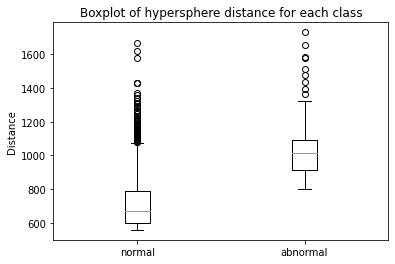

In [40]:
out_all, dist_all, score_all = [], [], []
for ix, data in tqdm(enumerate(val_loader)):
    output = model(data.to(device='cuda:1'))
    out_all.append(output.cpu().detach().numpy())
    # dist, score = anomaly_score(data_center, output, radius)
    dist = torch.sum((output - data_center) ** 2, dim=1)
    dist_all.append(dist.cpu().detach().numpy())
dist_all = np.concatenate(dist_all)

# new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius = np.quantile(np.sqrt(dist_all), 0.97)


out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(test_loader)):
    output = model(data.to(device='cuda:1'))
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, new_radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
dist_all = np.concatenate(dist_all)
score_all = np.concatenate(score_all)
    
normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

plt.boxplot([dist_all[normal], dist_all[abnormal]])
# plt.ylim(0, 1e3)
plt.xticks([1, 2],['normal', 'abnormal'])
plt.title('Boxplot of hypersphere distance for each class')
plt.ylabel('Distance')

/tmp/ipykernel_186070/3563274248.py:3: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.displot(data=dist_df, x='distance', hue='label_str', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))


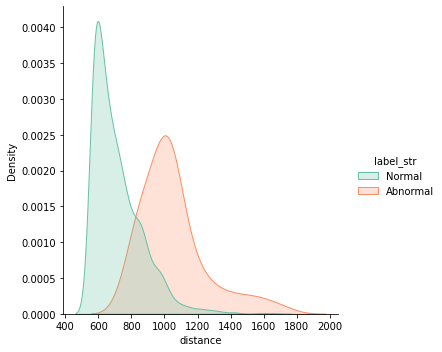

In [41]:
dist_df = pd.DataFrame([dist_all, label_all.reshape(-1)], index=['distance', 'label']).T
dist_df['label_str'] = dist_df['label'].apply(lambda s:'Normal' if s==0 else 'Abnormal')
sns.displot(data=dist_df, x='distance', hue='label_str', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))

# 5. Baseline Result

In [42]:
print(args.dataset)
baselines = pd.read_csv('result/{}_baselines.csv'.format(args.dataset), index_col=0)
baselines.head()

1210005301_CV2


,Kfold,Method,model,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,0,multivariate,SVM,0.087719,0.000000,1.000000,0.087719,0.975529,0.704775,0.574437,0.965419,0.270458
1,0,multivariate,MLP,0.140351,0.466667,0.533333,0.140351,0.973647,0.918508,0.604409,0.966093,0.386686
2,0,multivariate,Time-MLP,0.000000,NaN,0.000000,0.000000,0.973176,0.500000,0.493203,0.959947,0.026824
3,0,multivariate,Time-CNN,0.000000,1.000000,0.000000,0.000000,0.968471,0.820235,0.491991,0.957589,0.141885
4,0,multivariate,LSTM-FCN,0.175439,0.583333,0.416667,0.175439,0.971294,0.659591,0.616141,0.965560,0.147900


In [43]:
pd.pivot_table(baselines, index=['model'], aggfunc='mean')

/tmp/ipykernel_186070/282074762.py:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  pd.pivot_table(baselines, index=['model'], aggfunc='mean')


,AP,AUC,DR,F1_macro,F1_weight,Kfold,acc,far,precision,recall
model,,,,,,,,,,
DeepSAD,0.154793,0.770713,0.760636,0.419235,0.739998,4.5,0.619302,0.952136,0.047864,0.760636
DevNet,0.085326,0.822047,0.442010,0.543627,0.931407,4.5,0.902209,0.910577,0.089423,0.442010
LSTM-FCN,0.162554,0.592208,0.137544,0.567832,0.967644,4.5,0.973736,0.808025,0.172778,0.137544
MLP,0.272782,0.917085,0.245053,0.608512,0.969134,4.5,0.973262,0.651690,0.348310,0.245053
PReNet,0.215221,0.715244,0.503605,0.517379,0.905324,4.5,0.856913,0.932432,0.067568,0.503605
SVM,0.207318,0.795375,0.017105,0.510239,0.968442,4.5,0.978244,0.666667,0.200000,0.017105
Time-CNN,0.120520,0.777685,0.128778,0.526525,0.964933,4.5,0.970340,0.924228,0.068195,0.128778
Time-MLP,0.029476,0.574424,0.000000,0.494589,0.968145,4.5,0.978661,NaN,0.000000,0.000000


In [44]:
baseline_select = baselines[baselines.model.isin(['DevNet', 'PReNet', 'DeepSAD'])]
compare = pd.pivot_table(baseline_select, index=['model'], aggfunc='mean')
proposed = pd.pivot_table(result_all[(result_all.adjust==True)&(result_all.nu==0.2)],  index=['model'], aggfunc='mean')
pd.concat([compare, proposed])

/tmp/ipykernel_186070/4189926542.py:2: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  compare = pd.pivot_table(baseline_select, index=['model'], aggfunc='mean')


,AP,AUC,DR,F1_macro,F1_weight,Kfold,acc,far,precision,recall,adjust,nu
model,,,,,,,,,,,,
DeepSAD,0.154793,0.770713,0.760636,0.419235,0.739998,4.5,0.619302,0.952136,0.047864,0.760636,NaN,NaN
DevNet,0.085326,0.822047,0.442010,0.543627,0.931407,4.5,0.902209,0.910577,0.089423,0.442010,NaN,NaN
PReNet,0.215221,0.715244,0.503605,0.517379,0.905324,4.5,0.856913,0.932432,0.067568,0.503605,NaN,NaN
GAT,0.076173,0.715261,0.569867,0.493226,0.873956,4.5,0.805340,0.945665,0.054335,0.569867,1.0,0.2
GCN,0.064989,0.730963,0.560617,0.488145,0.868655,4.5,0.796819,0.948318,0.051682,0.560617,1.0,0.2
GraphSAGE,0.068774,0.751599,0.635564,0.497087,0.867860,4.5,0.794908,0.937726,0.062274,0.635564,1.0,0.2
STGCN,0.113177,0.874025,0.761422,0.512835,0.876159,4.5,0.807969,0.924289,0.075711,0.761422,1.0,0.2


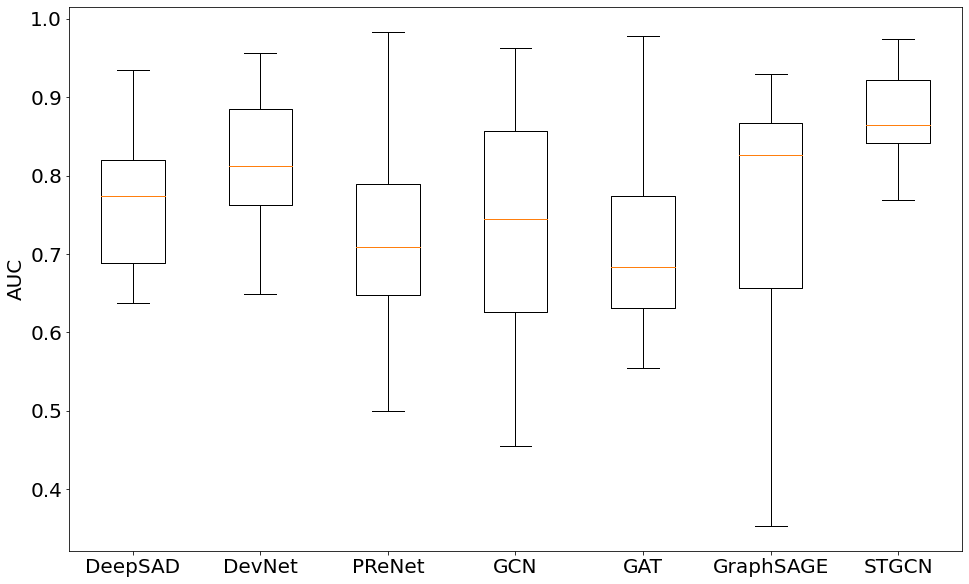

In [56]:
deepsad = baselines[baselines.model == 'DeepSAD']
devnet = baselines[baselines.model == 'DevNet']
prenet = baselines[baselines.model == 'PReNet']
nu = 0.2
gcn = result_all[(result_all.adjust==True)&(result_all.nu==nu)&(result_all.model=='GCN')]
gat = result_all[(result_all.adjust==True)&(result_all.nu==nu)&(result_all.model=='GAT')]
gsage = result_all[(result_all.adjust==True)&(result_all.nu==nu)&(result_all.model=='GraphSAGE')]
stgcn = result_all[(result_all.adjust==True)&(result_all.nu==nu)&(result_all.model=='STGCN')]


labels = ['DeepSAD', 'DevNet', 'PReNet', 'GCN', 'GAT','GraphSAGE','STGCN']
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 20})
plt.boxplot([deepsad.AUC, devnet.AUC, prenet.AUC, gcn.AUC, gat.AUC, gsage.AUC, stgcn.AUC], 
            labels=labels, showfliers=False)
plt.ylabel('AUC')
plt.savefig('images/AUC_boxplots.png')
plt.show()